# CNN for Particle Classification

In this notebook, we train 10 layers deep CNN for particle type classification ($e^-$, $\mu^-$, and $\gamma$) using the workshop dataset.

In [1]:
print('Importar Librerias')
from __future__ import print_function
from IPython.display import display
import torch, time
import numpy as np

Importar Librerias


In [2]:
import sys
print(sys.path)

['/home/cads/Documentos/making/Demos_H5/notebooks', '/home/cads/Documentos/making/Demos_H5/notebooks/iotools', '/home/cads/Documentos/making/Demos_H5/notebooks/utils', '/home/cads/anaconda3/lib/python39.zip', '/home/cads/anaconda3/lib/python3.9', '/home/cads/anaconda3/lib/python3.9/lib-dynload', '', '/home/cads/anaconda3/lib/python3.9/site-packages', '/home/cads/anaconda3/lib/python3.9/site-packages/locket-0.2.1-py3.9.egg', '/home/cads/anaconda3/lib/python3.9/site-packages/IPython/extensions', '/home/cads/.ipython']


In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import numpy as np
import torch
from sklearn.cluster import DBSCAN
import matplotlib
from sklearn.metrics import log_loss
from scipy.spatial.distance import cdist
from sklearn.cluster import DBSCAN

## Defining a network
Let's define our network. The design below consists of 7 convolution layers + 3 fully-connected layers (10 learnable layers). Here is a summary of the graph operations.
* Feature extractor:
    1. Input shape: (N,88,168,2) ... N samples of 88x168 2D images with 2 channels
    2. Convolution layer + ReLU, 16 filters, kernel size 3x3, stride 1 (default)
    3. 2D max-pooling, kernel size 2, stride 2
    4. 2x Convolution layer + ReLU, 32 filters, kernel size 3x3, stride 1 (default)
    5. 2D max-pooling, kernel size 2, stride 2
    6. 2x Convolution layer + ReLU, 64 filters, kernel size 3x3, stride 1 (default)
    7. 2D max-pooling, kernel size 2, stride 2
    8. 2x Convolution layer + ReLU, 128 filters, kernel size 3x3, stride 1 (default)
* Flattening
    9. 2D average-pooling, kernel size = 2D image spatial dimension at this point (results in length 128 1D array)
* Classifier:
    10. Fully-connected layer + ReLU, 128 filters
    11. Fully-connected layer + ReLU, 128 filters
    12. Fully-connected layer, M filters where M = number of classification categories

In [4]:
## EXTRA

# Dumb class to organize output csv file
class CSVData:

    def __init__(self,fout):
        self.name  = fout
        self._fout = None
        self._str  = None
        self._dict = {}

    def record(self, keys, vals):
        for i, key in enumerate(keys):
            self._dict[key] = vals[i]

    def write(self):
        if self._str is None:
            self._fout=open(self.name,'w')
            self._str=''
            for i,key in enumerate(self._dict.keys()):
                if i:
                    self._fout.write(',')
                    self._str += ','
                self._fout.write(key)
                self._str+='{:f}'
            self._fout.write('\n')
            self._str+='\n'

        self._fout.write(self._str.format(*(self._dict.values())))

    def flush(self):
        if self._fout: self._fout.flush()

    def close(self):
        if self._str is not None:
            self._fout.close()



In [5]:

print('Defining a network')

class CNN(torch.nn.Module):
    
    def __init__(self, num_class):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature = torch.nn.Sequential(
            torch.nn.Conv2d(2,16,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(16,32,3), torch.nn.ReLU(),
            torch.nn.Conv2d(32,32,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(32,64,3), torch.nn.ReLU(),
            torch.nn.Conv2d(64,64,3), torch.nn.ReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(64,128,3), torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3), torch.nn.ReLU())
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,num_class)
        )

    def forward(self, x):
        net = self._feature(x)
        net = torch.nn.AvgPool2d(net.size()[2:])(net)
        return self._classifier(net.view(-1,128))


Defining a network


## Defining a train loop
For convenience, define a _BLOB_ class to keep objects together. To a BLOB instance, we attach LeNet, our loss function (`nn.CrossEntropyLoss`), and Adam optimizer algorithm. For analysis purpose, we also include `nn.Softmax`. Finally, we attach data and label place holders.

In [6]:
print('Defining a train loop')
class BLOB:
    pass
blob=BLOB()
#blob.net       = CNN(3).cuda() # construct Lenet for 3 class classification, use GPU
blob.net       = CNN(3).cpu() # construct Lenet for 3 class classification, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

Defining a train loop


We define 2 functions to be called in the training loop: forward and backward. These functions implement the evaluation of the results, error (loss) definition, and propagation of errors (gradients) back to update the network parameters.

In [7]:
print('Defining forward')

def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        data = torch.as_tensor(blob.data).cpu()#[torch.as_tensor(d).cuda() for d in blob.data]
        data = data.permute(0,3,1,2)
        prediction = blob.net(data)
        # Training
        loss,acc=-1,-1
        if blob.label is not None:
            label = torch.as_tensor(blob.label).type(torch.LongTensor).cpu()#[torch.as_tensor(l).cuda() for l in blob.label]
            label.requires_grad = False
            loss = blob.criterion(prediction,label)
        blob.loss = loss
        
        softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=-1)
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())        
        prediction = prediction.cpu().detach().numpy()
        
        return {'prediction' : prediction,
                'softmax'    : softmax,
                'loss'       : loss.cpu().detach().item(),
                'accuracy'   : accuracy}

def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()


Defining forward


## Running a train loop 
Let's prepare the data loaders for both train and test datasets. We use the latter to check if the network suffers from overtraining.

In [8]:
print('Create data loader')

# Create data loader
from iotools import loader_factory
#DATA_DIRS=['/data/hkml_data/IWCDgrid/varyE/e-','/data/hkml_data/IWCDgrid/varyE/mu-','/data/hkml_data/IWCDgrid/varyE/gamma']
DATA_DIRS=['/home/cads/Documentos/making/Demos_H5/H5']
# for train
#train_loader=loader_factory('H5Dataset', batch_size=64, shuffle=True, num_workers=4, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.0, use_fraction=0.2)
train_loader=loader_factory('H5Dataset', batch_size=64, shuffle=True, num_workers=0, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.0, use_fraction=0.2)
# for validation
#test_loader=loader_factory('H5Dataset', batch_size=200, shuffle=True, num_workers=2, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.1, use_fraction=0.1)
test_loader=loader_factory('H5Dataset', batch_size=200, shuffle=True, num_workers=0, data_dirs=DATA_DIRS, flavour='100k.h5', start_fraction=0.1, use_fraction=0.1)

Create data loader


lso import `CSVData` from our utility module, which lets us write train log (accuracy, loss, etc.) in a csv file.

In [9]:
print('Progress bar')

# Import 0) progress bar and 1) data recording utility (into csv file)
###from utils import progress_bar, CSVData
#blob.train_log, blob.test_log = CSVData('log_train.csv'), CSVData('log_test.csv')
blob.train_log, blob.test_log = CSVData('/home/cads/Documentos/making/Demos_H5/log_train.csv'), CSVData('/home/cads/Documentos/making/Demos_H5/log_test.csv')

Progress bar


In [10]:
### EXtra
import time


# Decorative progress bar
def progress_bar(count, total, message=''):
    """
    Args: count .... int/float, current progress counter
          total .... int/float, total counter
          message .. string, appended after the progress bar
    """
    from IPython.display import HTML, display,clear_output
    return HTML("""
        <progress 
            value='{count}'
            max='{total}',
            style='width: 30%'
        >
            {count}
        </progress> {frac}% {message}
    """.format(count=count,total=total,frac=int(float(count)/float(total)*100.),message=message))


Finally, we're ready to run the training! Let's create a dataloader, write a loop to  call forward and backward.

In [11]:
print('train period')

# Define train period. "epoch" = N image consumption where N is the total number of train samples.
TRAIN_EPOCH=3.0
# Set the network to training mode
blob.net.train()
epoch=0.
iteration=0
# Start training
while int(epoch+0.5) < TRAIN_EPOCH:
    print('Epoch',int(epoch+0.5),'Starting @',time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()))
    # Create a progress bar for this epoch
    ### from utils import progress_bar
    progress = display(progress_bar(0,len(train_loader)),display_id=True)
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        # Data and label
        blob.data,blob.label = data[0:2]
        # Call forward: make a prediction & measure the average error
        res = forward(blob,True)
        # Call backward: backpropagate error and update weights
        backward(blob)
        # Epoch update
        epoch += 1./len(train_loader)
        iteration += 1
        
        #
        # Log/Report
        #
        # Record the current performance on train set
        blob.train_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
        blob.train_log.write()
        # once in a while, report
        if i==0 or (i+1)%10 == 0:
            message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
            progress.update(progress_bar((i+1),len(train_loader),message))
        # more rarely, run validation
        if (i+1)%100 == 0:
            with torch.no_grad():
                blob.net.eval()
                test_data = next(iter(test_loader))
                blob.data,blob.label = test_data[0:2]
                res = forward(blob,False)
                blob.test_log.record(['iteration','epoch','accuracy','loss'],[iteration,epoch,res['accuracy'],res['loss']])
                blob.test_log.write()
            blob.net.train()
        if epoch >= TRAIN_EPOCH:
            break
    message = '... Iteration %d ... Epoch %1.2f ... Loss %1.3f ... Accuracy %1.3f' % (iteration,epoch,res['loss'],res['accuracy'])
    progress.update(progress_bar((i+1),len(train_loader),message))

blob.test_log.close()
blob.train_log.close()

train period
Epoch 0 Starting @ 2022-02-24 08:48:48


Epoch 1 Starting @ 2022-02-24 09:06:40


Epoch 2 Starting @ 2022-02-24 09:22:40


## Inspecting the training process
Let's plot the train log for both train and test set.

Inspecting the training process


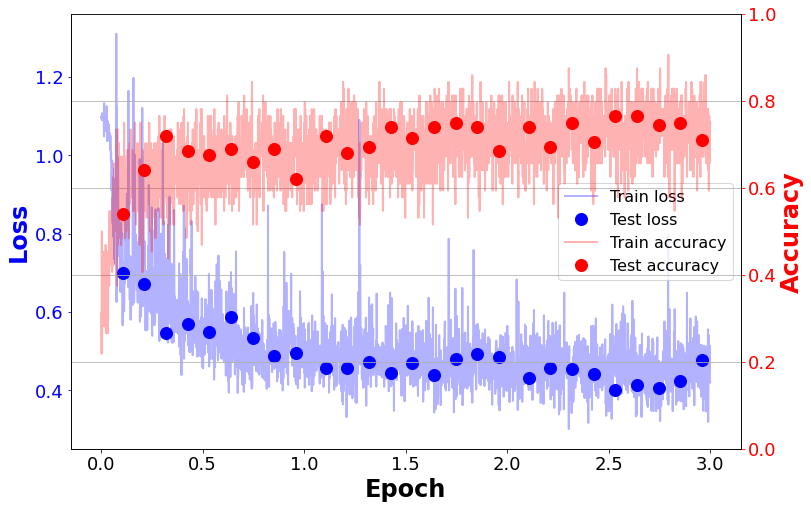

In [12]:
print('Inspecting the training process')
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

train_log = pd.read_csv(blob.train_log.name)
test_log  = pd.read_csv(blob.test_log.name)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Train loss', color='b', alpha=0.3)
line12 = ax1.plot(test_log.epoch, test_log.loss, marker='o', markersize=12, linestyle='', label='Test loss', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Train accuracy', color='r', alpha=0.3)
line22 = ax2.plot(test_log.epoch, test_log.accuracy, marker='o', markersize=12, linestyle='', label='Test accuracy', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()

We see the loss is coming down while the accuracy is increasing. These two should be anti-correlated, so this is expected. We also see the network performance on the test dataset (circles) follow those of train dataset (lines). This means there is no apparent overtraining.

**Question: is the network still learning?**
Both the loss and accuracy curve have large fluctuations and it is somewhat hard to see if the values are still changing. Let's plot the moving average of the loss and accuracy values.

def moving_average


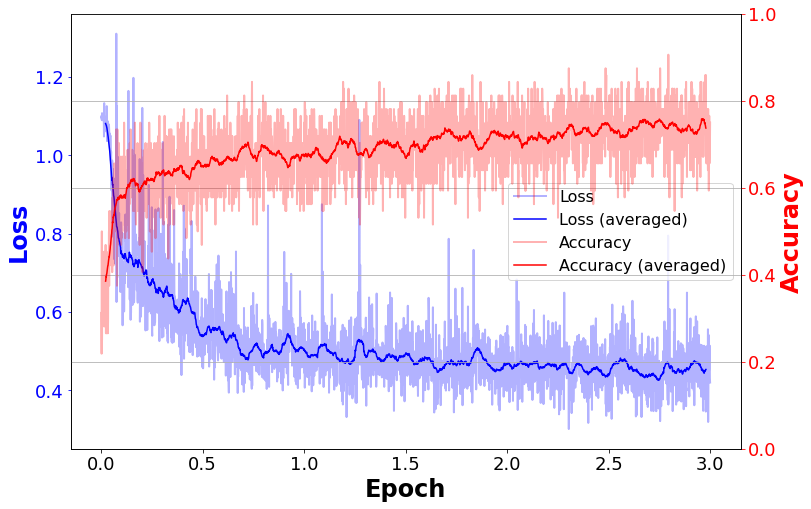

In [13]:
print('def moving_average')
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

epoch    = moving_average(np.array(train_log.epoch),40)
accuracy = moving_average(np.array(train_log.accuracy),40)
loss     = moving_average(np.array(train_log.loss),40)

fig, ax1 = plt.subplots(figsize=(12,8),facecolor='w')
line11 = ax1.plot(train_log.epoch, train_log.loss, linewidth=2, label='Loss', color='b', alpha=0.3)
line12 = ax1.plot(epoch, loss, label='Loss (averaged)', color='blue')
ax1.set_xlabel('Epoch',fontweight='bold',fontsize=24,color='black')
ax1.tick_params('x',colors='black',labelsize=18)
ax1.set_ylabel('Loss', fontsize=24, fontweight='bold',color='b')
ax1.tick_params('y',colors='b',labelsize=18)

ax2 = ax1.twinx()
line21 = ax2.plot(train_log.epoch, train_log.accuracy, linewidth=2, label='Accuracy', color='r', alpha=0.3)
line22 = ax2.plot(epoch, accuracy, label='Accuracy (averaged)', color='red')

ax2.set_ylabel('Accuracy', fontsize=24, fontweight='bold',color='r')
ax2.tick_params('y',colors='r',labelsize=18)
ax2.set_ylim(0.,1.0)

# added these four lines
lines  = line11 + line12 + line21 + line22
labels = [l.get_label() for l in lines]
leg    = ax1.legend(lines, labels, fontsize=16, loc=5)
leg_frame = leg.get_frame()
leg_frame.set_facecolor('white')

plt.grid()
plt.show()


The tick lines now represent the moving average (all data points are from the train log). It appears the network is still learning. We can train for a longer period to achieve a better accuracy.

## Performance Analysis
Beyond looking at the performance of the network, we can analyze how the network is performing for each classification target. Let's first obtain a high-statistics analysis output by running the network on all test samples.

In [14]:
print('def inference')
def inference(blob,data_loader):
    label,prediction,accuracy=[],[],[]
    # set the network to test (non-train) mode
    blob.net.eval()
    # create the result holder
    index,label,prediction = [],[],[]
    for i,data in enumerate(data_loader):
        blob.data, blob.label = data[0:2]
        res = forward(blob,True)
        accuracy.append(res['accuracy'])
        prediction.append(res['prediction'])
        label.append(blob.label)
        #if i==2: break
    # report accuracy
    accuracy   = np.array(accuracy,dtype=np.float32)
    label      = np.hstack(label)
    prediction = np.hstack(prediction)
    
    return accuracy, label, prediction

def inference


Let's run the inference using this function on the test sample, and look at the error matrix.

In [15]:
# Plot a confusion matrix
def plot_confusion_matrix(label,prediction,class_names):
    """
    Args: label ... 1D array of true label value, the length = sample size
          prediction ... 1D array of predictions, the length = sample size
          class_names ... 1D array of string label for classification targets, the length = number of categories
    """
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(12,8),facecolor='w')
    num_labels = len(class_names)
    max_value  = np.max([np.max(np.unique(label)),np.max(np.unique(label))])
    assert max_value < num_labels
    mat,_,_,im = ax.hist2d(label,prediction,
                           bins=(num_labels,num_labels),
                           range=((-0.5,num_labels-0.5),(-0.5,num_labels-0.5)),cmap=plt.cm.Blues)
    plt.colorbar(im, ax=ax)
    ax.set_xticks(np.arange(num_labels))
    ax.set_yticks(np.arange(num_labels))
    ax.set_xticklabels(class_names,fontsize=16)
    ax.set_yticklabels(class_names,fontsize=16)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_xlabel('Prediction',fontsize=20)
    ax.set_ylabel('True Label',fontsize=20)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            ax.text(i,j, str(mat[i, j]),
                    ha="center", va="center", fontsize=16,
                    color="white" if mat[i,j] > (0.5*mat.max()) else "black")
    fig.tight_layout()
    plt.show()



plot_confusion_matrix
Accuracy mean 0.73116666 std 0.027901111


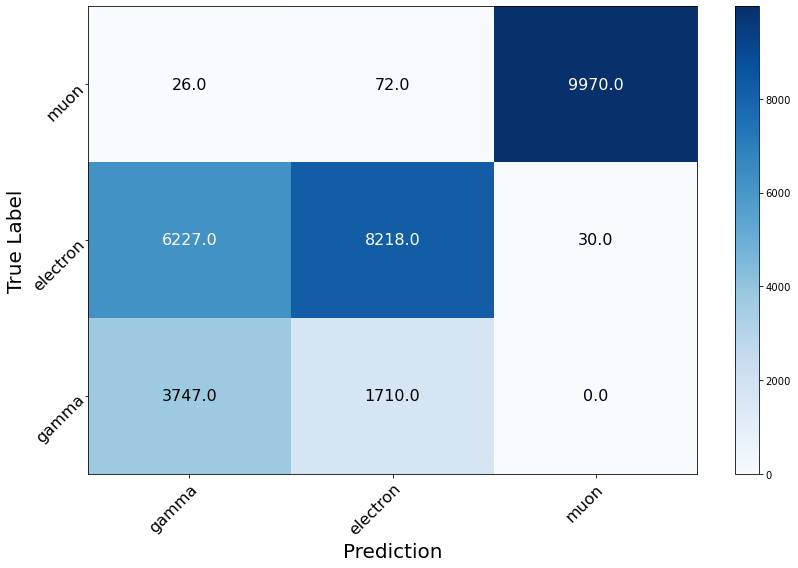

In [17]:
print('plot_confusion_matrix')

#from utils import plot_confusion_matrix
accuracy,label,prediction = inference(blob,test_loader)
print('Accuracy mean',accuracy.mean(),'std',accuracy.std())
plot_confusion_matrix(label,prediction,['gamma','electron','muon'])

As one may expect, muon is distinguished fairly well while there is some confusion between electron and gamma ray.